## This script is to generate and collect Yoga postures using Open CV as well as MediaPipe 

In [ ]:
!pip install pyttsx3

In [7]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
mp_drawing = mp.solutions.drawing_utils #gives all our drawing utilities, visualise our poses
mp_pose = mp.solutions.pose #importing pose estimation models
pose = mp_pose.Pose(static_image_mode=True)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import pyttsx3  # Text-to-speech engine
import time

I0000 00:00:1750522428.057748  339261 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1750522428.127091  341078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750522428.152155  341082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


## Calculating Angles

In [8]:
def calculate_angle(a,b,c):
    a=np.array(a)#First
    b=np.array(b)#Second
    c=np.array(c)#Third
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360.0-angle
        
    return angle
                                                        
    

## Determining Joints

In [9]:
# Dataset path
DATASET_DIR = 'DATASET/TEST'
data = []

In [4]:
cap = cv2.VideoCapture(0)
#setting up mediapipe instance
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret,frame = cap.read()
        
        #detect stuff and render
        
        #recolour the image
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#mediapipe feed is always obtained in BGR
        image.flags.writeable = False 
        
        #make detection
        results = pose.process(image)
        
        #recolouring back to BGR 
        image.flags.writeable = True
        image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)#recolouring back to BGR because we will feed it back to opencv which takes the BGR encoding
        
        #Extract Landmarks
        try:
            landmarks = results.pose_landmarks.landmark
            row = []
            for lm in landmarks:
                row.extend([lm.x, lm.y, lm.z, lm.visibility])
                
                        # Get key points for angles
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

            # Calculate angles
            elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)

            # Append angles to row
            row.extend([elbow_angle, knee_angle])

            # Append full row to data
            data.append(row)
    

        except Exception as e:
            print(f"Error: {e}")
            
            
        # Render pose landmarks
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
            )
            
        cv2.imshow('Pose Detection - Press Q to Quit', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break #breaking off of our feed
    cap.release()
    cv2.destroyAllWindows()
    
    # Save data to CSV
    columns = []
    for i in range(33):
        columns += [f'x{i}', f'y{i}', f'z{i}', f'v{i}']
    columns += ['elbow_angle', 'knee_angle']

    df = pd.DataFrame(data, columns=columns)
    df.to_csv('yoga_pose_data.csv', index=False)
    print("✅ Data saved to 'yoga_pose_data.csv'")

2025-06-21 21:41:22.054 python[23118:339261] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1750522283.113254  339261 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1750522283.176569  339559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750522283.189419  339565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Error: 'NoneType' object has no attribute 'landmark'


W0000 00:00:1750522283.393221  339563 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


✅ Data saved to 'yoga_pose_data.csv'


## Generating Test/Train Data
only run this cell 1 time
change the path name for train/test

## extract Pose Landmarks and angles using this mapping from MediaPipe

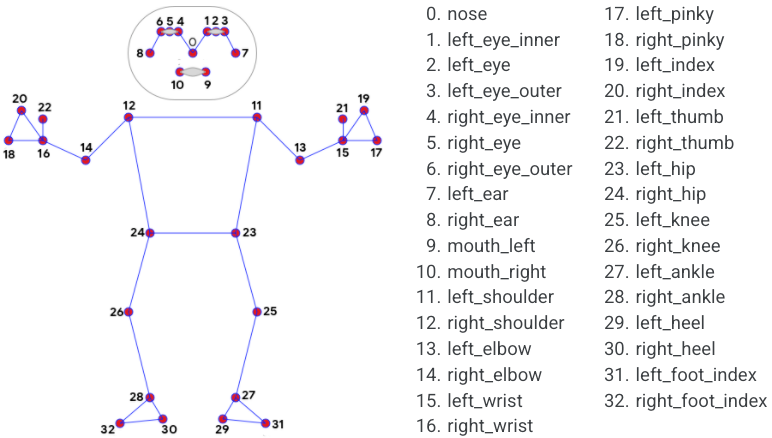

In [10]:
# Go through each pose folder
for pose_name in os.listdir(DATASET_DIR):
    pose_folder = os.path.join(DATASET_DIR, pose_name)
    if not os.path.isdir(pose_folder):
        continue

    for image_name in os.listdir(pose_folder):
        image_path = os.path.join(pose_folder, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image {image_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # Extract required coordinates
            def get_coords(index):
                lm = landmarks[index]
                return [lm.x, lm.y]

            try:
                # Joint Angles (you can add more!)
                left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
                right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
                left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
                right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
                left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
                right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
                left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
                right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
                left_ankle = calculate_angle(get_coords(25),get_coords(27),get_coords(31))
                right_ankle = calculate_angle(get_coords(26),get_coords(28),get_coords(32))
                left_wrist = calculate_angle(get_coords(19),get_coords(15),get_coords(13))
                right_wrist = calculate_angle(get_coords(20),get_coords(16),get_coords(14))

                # Spine angle (between hips and shoulders)
                spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))  # left_hip, left_shoulder, right_shoulder

                # Nose position
                nose_x = landmarks[0].x
                nose_y = landmarks[0].y

                row = {
                    'pose': pose_name,
                    'left_elbow': left_elbow,
                    'right_elbow': right_elbow,
                    'left_shoulder': left_shoulder,
                    'right_shoulder': right_shoulder,
                    'left_knee': left_knee,
                    'right_knee': right_knee,
                    'left_hip': left_hip,
                    'right_hip': right_hip,
                    'left_ankle':left_ankle,
                    'right_ankle':right_ankle,
                    'left_wrist':left_wrist,
                    'right_wrist':right_wrist,
                    'spine_angle': spine_angle,
                    'nose_x': nose_x,
                    'nose_y': nose_y
                }

                data.append(row)

            except IndexError as e:
                print(f"Missing keypoints in image {image_path}: {e}")
        else:
            print(f"No pose detected in {image_path}")

# Save to CSV
df = pd.DataFrame(data)
df.to_csv('test1.csv', index=False)
print("✅ Dataset saved to test.csv")

No pose detected in DATASET/TEST/downdog/00000010.png
No pose detected in DATASET/TEST/downdog/00000120.jpg
No pose detected in DATASET/TEST/downdog/00000080.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


No pose detected in DATASET/TEST/warrior2/00000039.png
No pose detected in DATASET/TEST/warrior2/00000025.png


libpng warning: iCCP: known incorrect sRGB profile


✅ Dataset saved to test.csv


## Importing the dataset

In [11]:
data = pd.read_csv('yoga_pose_angles_dataset.csv')
data.head()
test = pd.read_csv('test.csv')
test.head()

pose  left_elbow  right_elbow  left_shoulder  right_shoulder  \
0  downdog  167.693021   146.477287     164.628165      167.474764   
1  downdog  167.778737   171.478407     170.404824      170.764446   
2  downdog  174.131885   176.036629     157.693843      159.843692   
3  downdog  163.359692   163.027486     178.638414      179.166575   
4  downdog  171.174227   170.219702     161.301215      165.340695   

    left_knee  right_knee   left_hip  right_hip  left_ankle  right_ankle  \
0  179.416161  178.957185  56.959638  55.564091  107.129178   123.031251   
1  175.411938  179.641601  55.872988  54.564824  123.986836   121.064671   
2  174.442707  175.302202  64.091930  63.252336  115.008571   117.075565   
3  178.063533  179.391718  47.447562  45.265356  115.442956   114.711777   
4  177.141692  175.676876  59.969917  57.832232  110.994639   117.968654   

   left_wrist  right_wrist  spine_angle    nose_x    nose_y  
0  131.231872   155.978965    30.525809  0.371846  0.536924  
1  131.815457   154.683478    19.489615  0.359998  0.703226  
2  120.929693   146.188397    22.016090  0.243849  0.661045  
3  149.503824   132.009274   110.355853  0.626492  0.704183  
4  136.637961   150.583100    64.159325  0.467116  0.623466

## Checking the angles calculated for a randomly selected image for each pose

I0000 00:00:1750522473.933774  339261 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1750522473.998029  341545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750522474.011461  341550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


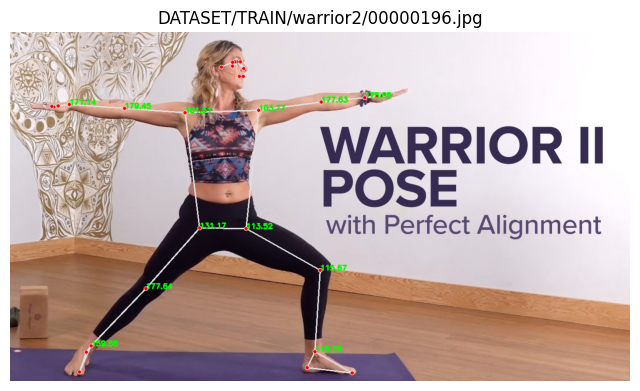

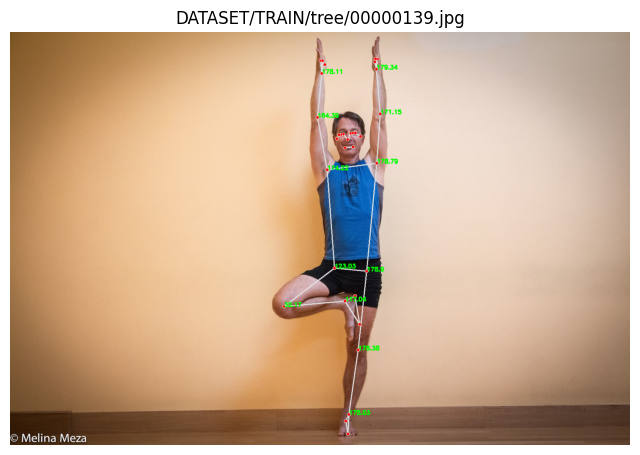

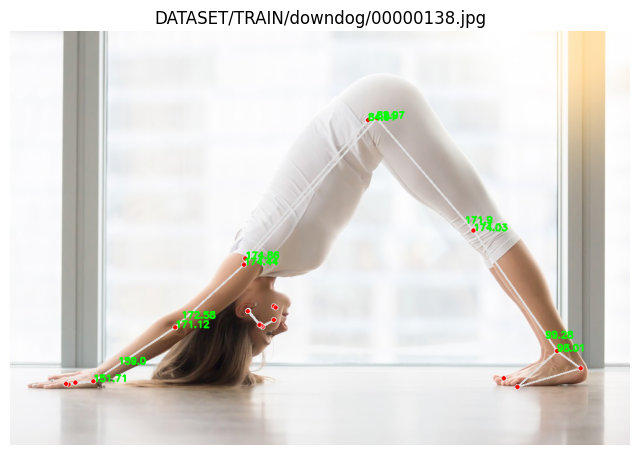

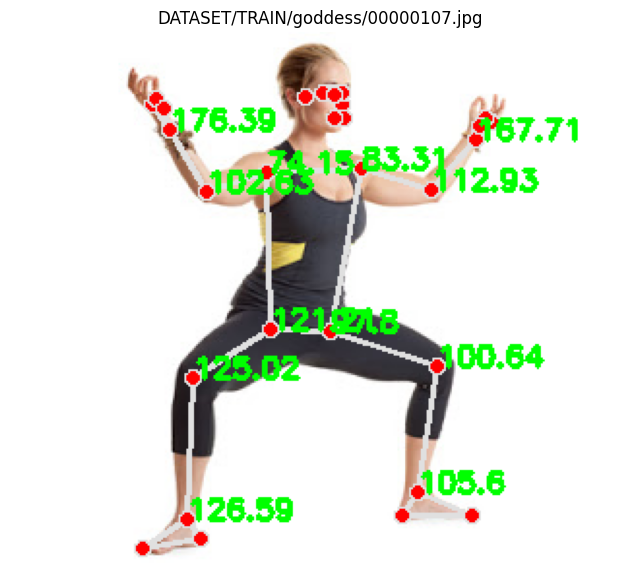

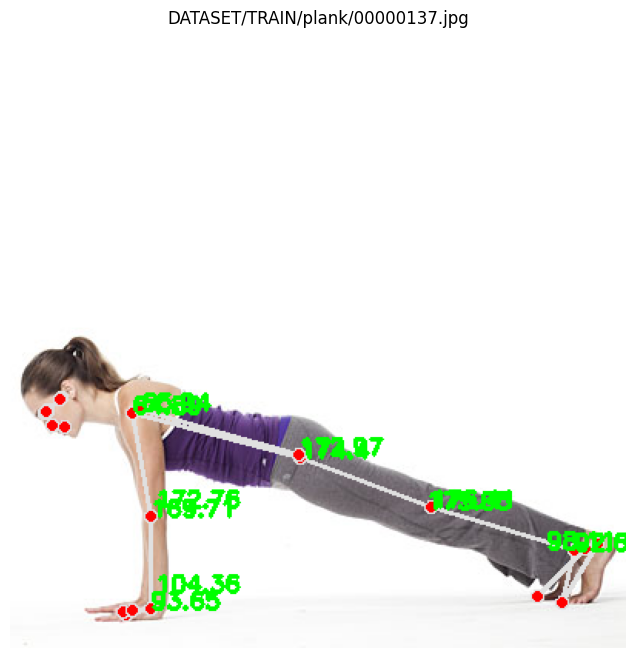

In [12]:
# 📝 Manually define your 5 image paths
image_paths = [
    "DATASET/TRAIN/warrior2/00000196.jpg",
    "DATASET/TRAIN/tree/00000139.jpg",
    "DATASET/TRAIN/downdog/00000138.jpg",
    "DATASET/TRAIN/goddess/00000107.jpg",
    "DATASET/TRAIN/plank/00000137.jpg"
]

# Process images
with mp_pose.Pose(static_image_mode=True) as pose:
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            def get_coords(index):
                lm = landmarks[index]
                return [lm.x * image.shape[1], lm.y * image.shape[0]]

            try:
                # Example angles
                left_shoulder = get_coords(mp_pose.PoseLandmark.LEFT_SHOULDER.value)
                left_elbow = get_coords(mp_pose.PoseLandmark.LEFT_ELBOW.value)
                left_wrist = get_coords(mp_pose.PoseLandmark.LEFT_WRIST.value)
                left_index = get_coords(mp_pose.PoseLandmark.LEFT_INDEX.value)
                

                left_hip = get_coords(mp_pose.PoseLandmark.LEFT_HIP.value)
                left_knee = get_coords(mp_pose.PoseLandmark.LEFT_KNEE.value)
                left_ankle = get_coords(mp_pose.PoseLandmark.LEFT_ANKLE.value)
                left_foot_index = get_coords(mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value)
                
                right_shoulder = get_coords(mp_pose.PoseLandmark.RIGHT_SHOULDER.value)
                right_elbow = get_coords(mp_pose.PoseLandmark.RIGHT_ELBOW.value)
                right_wrist = get_coords(mp_pose.PoseLandmark.RIGHT_WRIST.value)
                right_index = get_coords(mp_pose.PoseLandmark.RIGHT_INDEX.value)

                right_hip = get_coords(mp_pose.PoseLandmark.RIGHT_HIP.value)
                right_knee = get_coords(mp_pose.PoseLandmark.RIGHT_KNEE.value)
                right_ankle = get_coords(mp_pose.PoseLandmark.RIGHT_ANKLE.value)
                right_foot_index = get_coords(mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value)

                left_elbow_angle = calculate_angle(left_shoulder, left_elbow, left_wrist)
                left_shoulder_angle = calculate_angle(left_elbow,left_shoulder, left_hip)
                left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
                left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
                left_ankle_angle = calculate_angle(left_foot_index,left_ankle,left_knee)
                left_wrist_angle = calculate_angle(left_index,left_wrist,left_elbow)
                
                
                right_elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
                right_shoulder_angle = calculate_angle(right_elbow, right_shoulder, right_hip)
                right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
                right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)
                right_ankle_angle = calculate_angle(right_foot_index,right_ankle,right_knee)
                right_wrist_angle = calculate_angle(right_index,right_wrist,right_elbow)

                annotated = image.copy()
                mp_drawing.draw_landmarks(annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                angles= [
                    (left_shoulder_angle,left_shoulder),
                    (left_elbow_angle,left_elbow),
                    (left_hip_angle,left_hip),
                    (left_knee_angle,left_knee),
                    (left_ankle_angle,left_ankle),
                    (left_wrist_angle,left_wrist),
                    (right_shoulder_angle,right_shoulder),
                    (right_elbow_angle,right_elbow),
                    (right_hip_angle,right_hip),
                    (right_knee_angle,right_knee),
                    (right_ankle_angle,right_ankle),
                    (right_wrist_angle,right_wrist)
                ]
                
                for angle,coords in angles:

                    cv2.putText(annotated, f"{round(angle, 2)}", tuple(np.int32(coords)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            

                # Display
                plt.figure(figsize=(8, 8))
                plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
                plt.title(image_path)
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

        else:
            print(f"No pose detected in: {image_path}")

## Class Distribution Plot

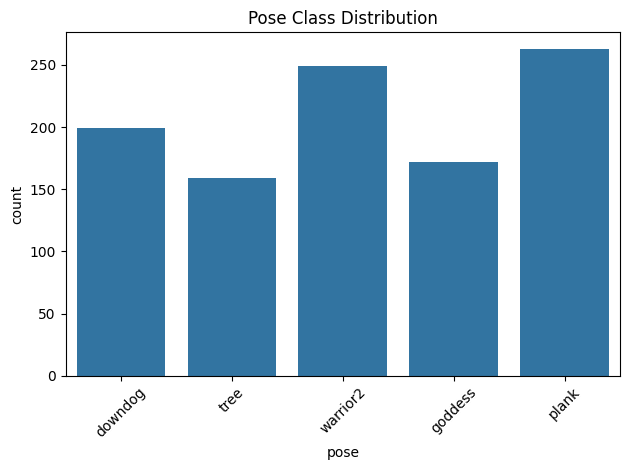

In [13]:
sns.countplot(x='pose', data=data)
plt.title('Pose Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Pairplot or Joint Angle Distribution by Pose

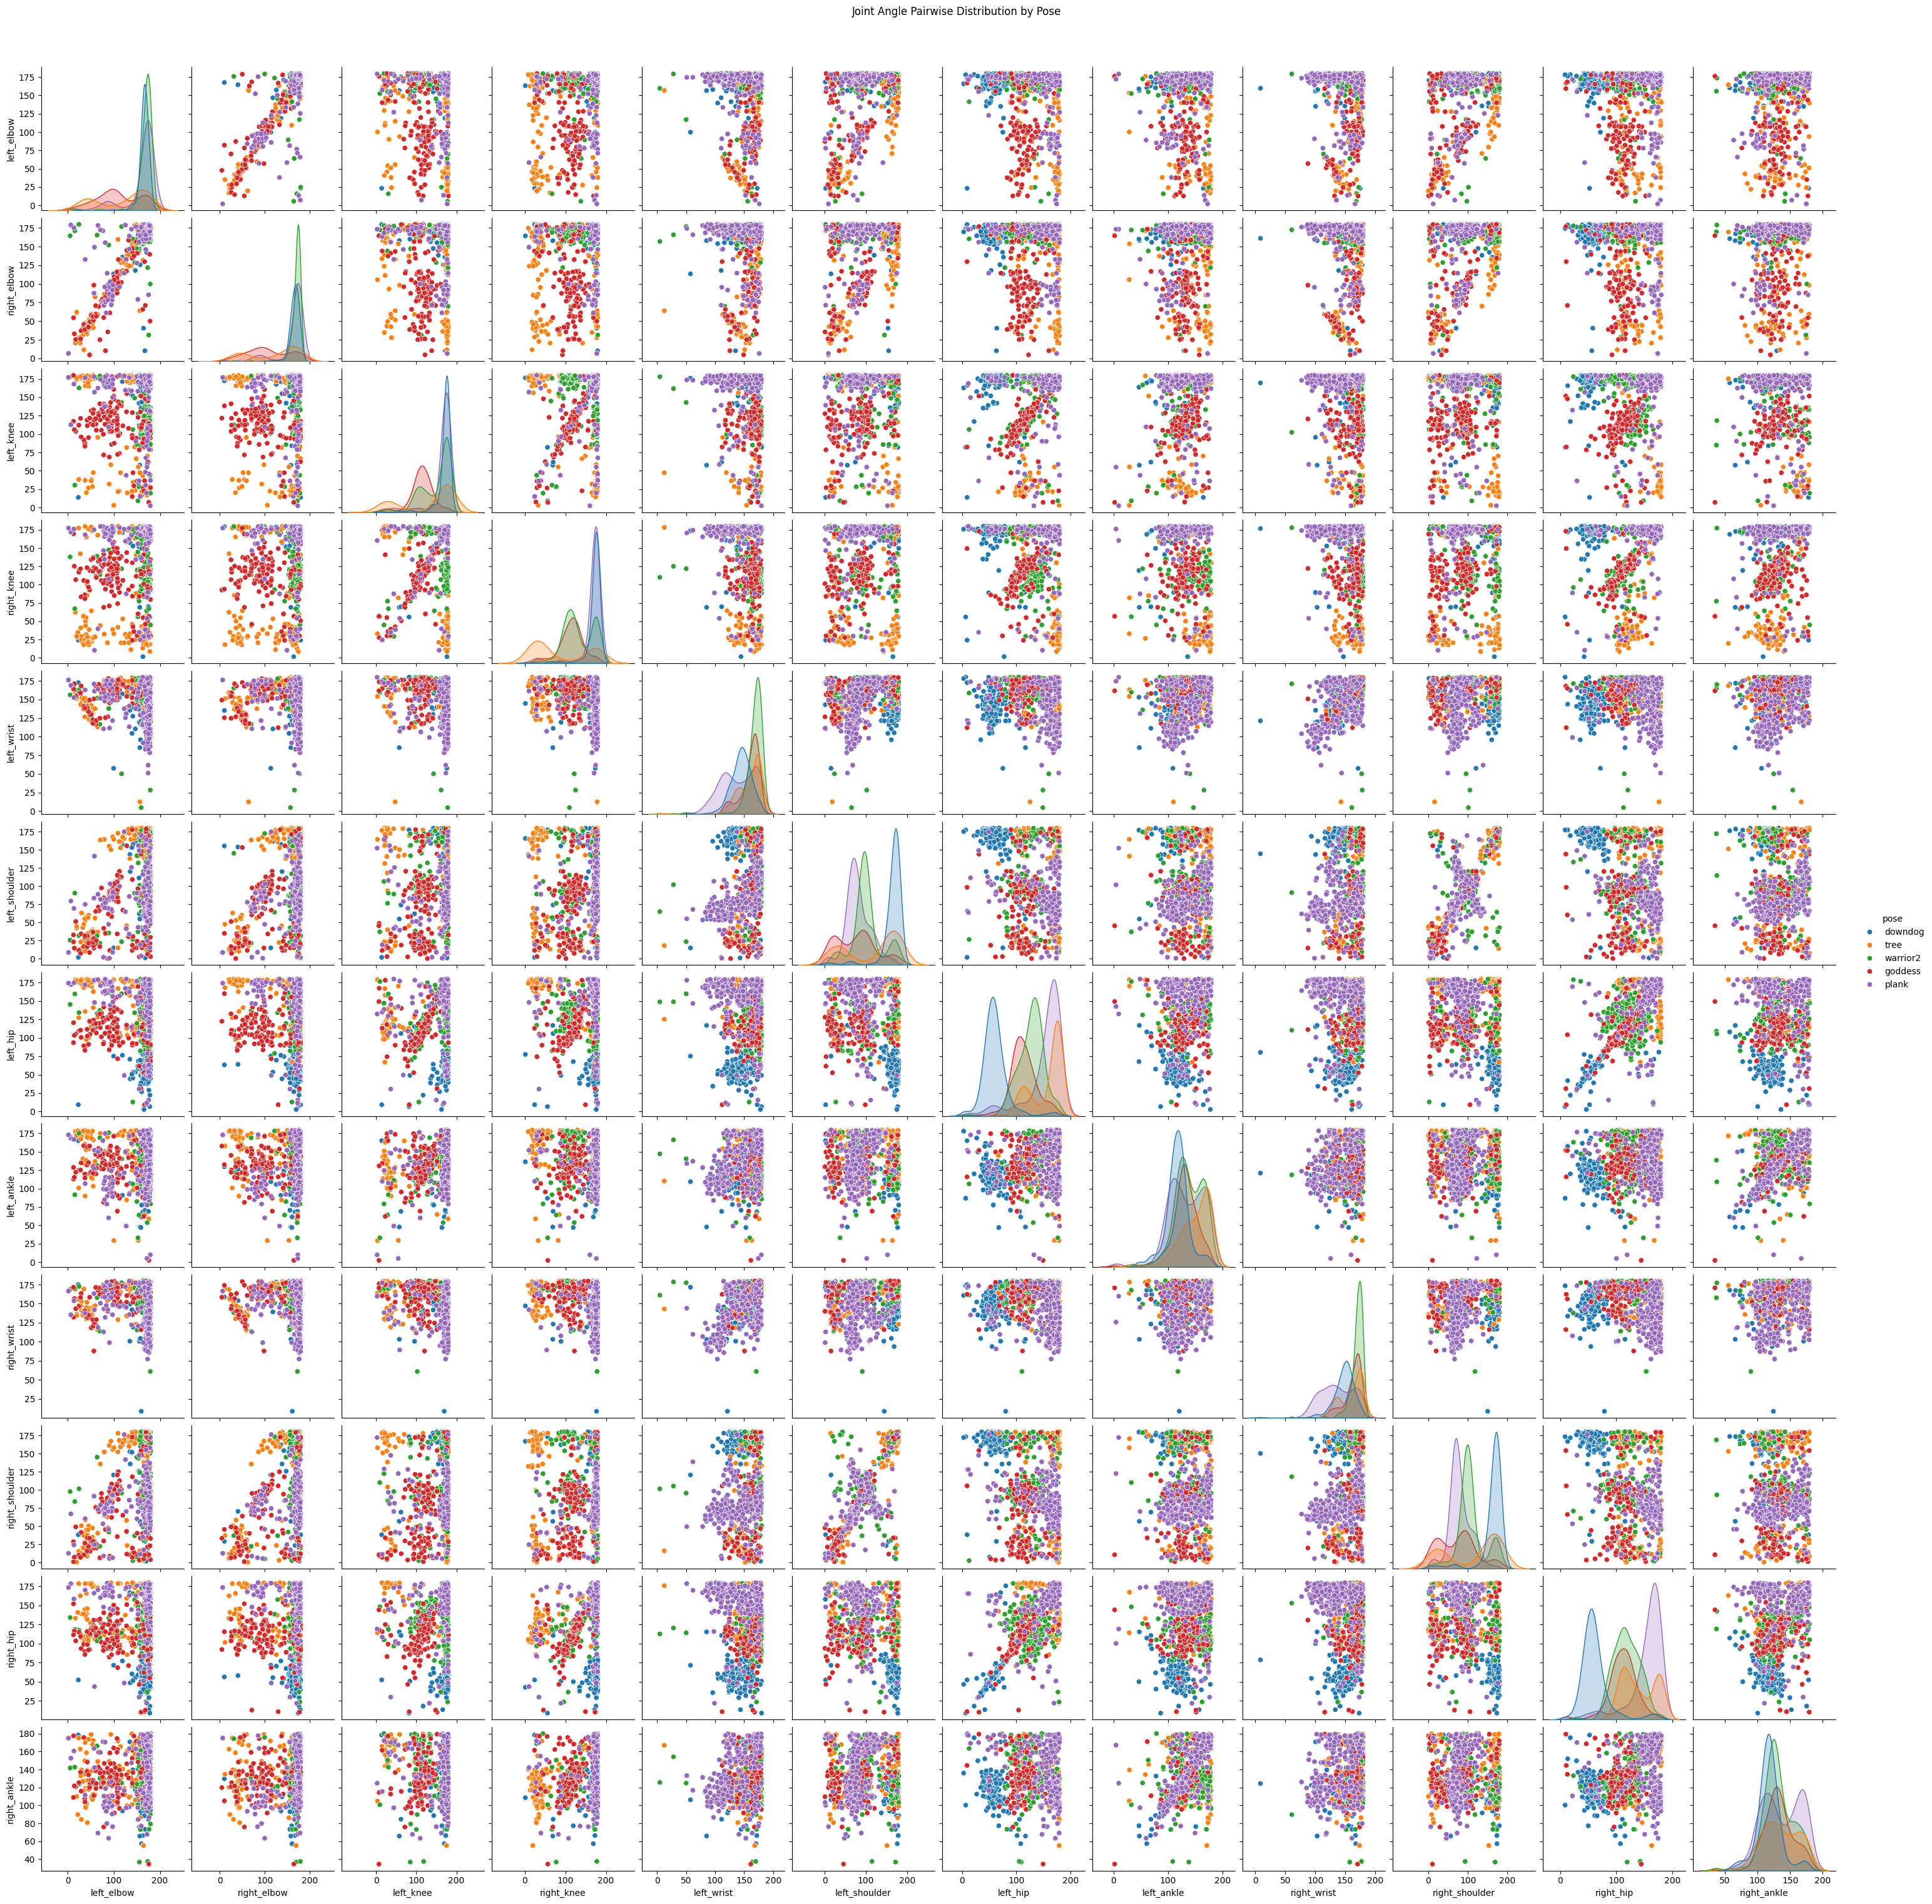

In [14]:
angle_cols = ['left_elbow', 'right_elbow', 'left_knee', 'right_knee','left_wrist' , 'left_shoulder','left_hip','left_ankle','right_wrist' , 'right_shoulder','right_hip','right_ankle']
sns.pairplot(data[angle_cols + ['pose']], hue='pose', diag_kind='kde')
plt.suptitle('Joint Angle Pairwise Distribution by Pose', y=1.02)
plt.show()


## Heatmap of Correlation Between Angles

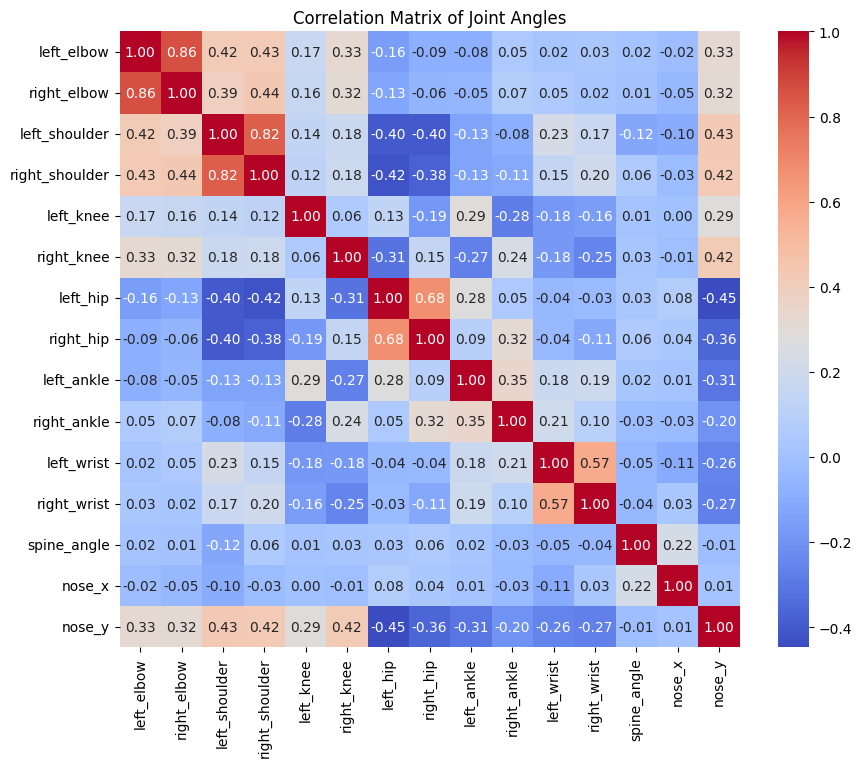

In [15]:
plt.figure(figsize=(10, 8))
corr_matrix = data.drop(columns=['pose']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Joint Angles')
plt.show()


## Boxplot of Joint Angles Per Pose

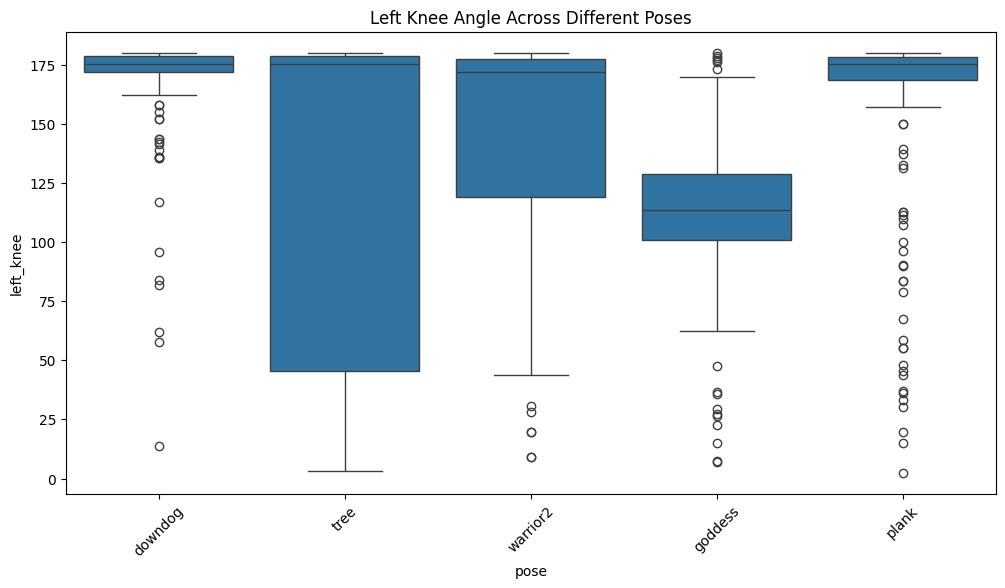

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='pose', y='left_knee', data=data)
plt.title('Left Knee Angle Across Different Poses')
plt.xticks(rotation=45)
plt.show()


 can view for the other angles as well ...if necessary

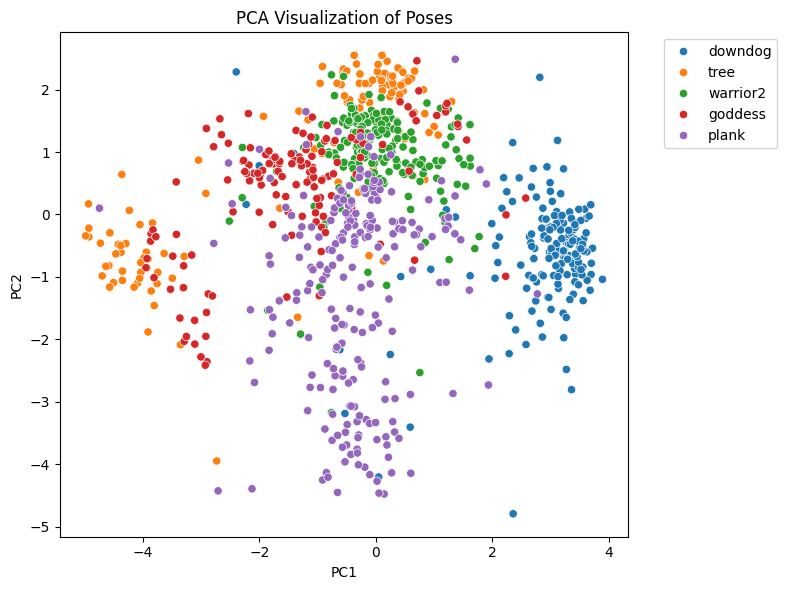

In [17]:
features = data.drop(columns=['pose'])
features_scaled = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=data['pose'], palette='tab10')
plt.title('PCA Visualization of Poses')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Preprocesing

## Encoding the Pose Labels 

In [18]:
le = LabelEncoder()
data['label_encoded'] = le.fit_transform(data['pose']) 
test['label_encoded'] = le.fit_transform(test['pose'])

In [19]:
test.head()

pose  left_elbow  right_elbow  left_shoulder  right_shoulder  \
0  downdog  167.693021   146.477287     164.628165      167.474764   
1  downdog  167.778737   171.478407     170.404824      170.764446   
2  downdog  174.131885   176.036629     157.693843      159.843692   
3  downdog  163.359692   163.027486     178.638414      179.166575   
4  downdog  171.174227   170.219702     161.301215      165.340695   

    left_knee  right_knee   left_hip  right_hip  left_ankle  right_ankle  \
0  179.416161  178.957185  56.959638  55.564091  107.129178   123.031251   
1  175.411938  179.641601  55.872988  54.564824  123.986836   121.064671   
2  174.442707  175.302202  64.091930  63.252336  115.008571   117.075565   
3  178.063533  179.391718  47.447562  45.265356  115.442956   114.711777   
4  177.141692  175.676876  59.969917  57.832232  110.994639   117.968654   

   left_wrist  right_wrist  spine_angle    nose_x    nose_y  label_encoded  
0  131.231872   155.978965    30.525809  0.371846  0.536924              0  
1  131.815457   154.683478    19.489615  0.359998  0.703226              0  
2  120.929693   146.188397    22.016090  0.243849  0.661045              0  
3  149.503824   132.009274   110.355853  0.626492  0.704183              0  
4  136.637961   150.583100    64.159325  0.467116  0.623466              0

In [20]:
X_train = data.drop(columns=['pose','label_encoded'])
X_test = test.drop(columns = ['pose','label_encoded'])
X_test.head()
y_train = data['label_encoded']
y_test = test['label_encoded']
X_test.head()

left_elbow  right_elbow  left_shoulder  right_shoulder   left_knee  \
0  167.693021   146.477287     164.628165      167.474764  179.416161   
1  167.778737   171.478407     170.404824      170.764446  175.411938   
2  174.131885   176.036629     157.693843      159.843692  174.442707   
3  163.359692   163.027486     178.638414      179.166575  178.063533   
4  171.174227   170.219702     161.301215      165.340695  177.141692   

   right_knee   left_hip  right_hip  left_ankle  right_ankle  left_wrist  \
0  178.957185  56.959638  55.564091  107.129178   123.031251  131.231872   
1  179.641601  55.872988  54.564824  123.986836   121.064671  131.815457   
2  175.302202  64.091930  63.252336  115.008571   117.075565  120.929693   
3  179.391718  47.447562  45.265356  115.442956   114.711777  149.503824   
4  175.676876  59.969917  57.832232  110.994639   117.968654  136.637961   

   right_wrist  spine_angle    nose_x    nose_y  
0   155.978965    30.525809  0.371846  0.536924  
1   154.683478    19.489615  0.359998  0.703226  
2   146.188397    22.016090  0.243849  0.661045  
3   132.009274   110.355853  0.626492  0.704183  
4   150.583100    64.159325  0.467116  0.623466

## Train a Classifier

In [22]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9913978494623656
              precision    recall  f1-score   support

     downdog       1.00      0.99      0.99        94
     goddess       0.99      0.97      0.98        80
       plank       0.99      1.00      1.00       115
        tree       1.00      1.00      1.00        69
    warrior2       0.98      0.99      0.99       107

    accuracy                           0.99       465
   macro avg       0.99      0.99      0.99       465
weighted avg       0.99      0.99      0.99       465



## Save the Classifier

In [23]:

joblib.dump(clf, 'pose_classifier.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

## Check whether the model works well with the webcam feed and is able to identify the poses


In [ ]:
# Load model & label encoder
clf = joblib.load('pose_classifier.pkl')

cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        label = 'No Yoga Pose Detected'

        try:
            landmarks = results.pose_landmarks.landmark

            def get_coords(idx):
                lm = landmarks[idx]
                return [lm.x, lm.y]

            # Calculate angles
            left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
            right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
            left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
            right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
            left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
            right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
            left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
            right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
            left_ankle = calculate_angle(get_coords(25), get_coords(27), get_coords(31))
            right_ankle = calculate_angle(get_coords(26), get_coords(28), get_coords(32))
            left_wrist = calculate_angle(get_coords(19), get_coords(15), get_coords(13))
            right_wrist = calculate_angle(get_coords(20), get_coords(16), get_coords(14))
            spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))
            nose_x = landmarks[0].x
            nose_y = landmarks[0].y

            # Arrange angles in order
            angles = [
                left_elbow, right_elbow,
                left_shoulder, right_shoulder,
                left_knee, right_knee,
                left_hip, right_hip,
                left_ankle, right_ankle,
                left_wrist, right_wrist,
                spine_angle,
                nose_x, nose_y
            ]

            # Create DataFrame with correct column names
            feature_cols = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder',
                            'left_knee', 'right_knee', 'left_hip', 'right_hip',
                            'left_ankle', 'right_ankle', 'left_wrist', 'right_wrist',
                            'spine_angle', 'nose_x', 'nose_y']
            X_live = pd.DataFrame([angles], columns=feature_cols)

            # Predict
            pred = clf.predict(X_live)[0]
            label = le.inverse_transform([pred])[0]

            # Display pose name
            cv2.putText(image, f"Pose: {label}", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3, cv2.LINE_AA)

        except:
            label = 'No Yoga Pose Detected'

        # Draw pose landmarks
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Show webcam feed
        cv2.imshow('Yoga Pose Detection', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## Add correctness feedback

In [ ]:
# Load model and label encoder
le = joblib.load("label_encoder.pkl")

# Compute mean joint angles per pose
mean_angles_per_pose = data.groupby('pose').mean()


cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        label = "No yoga pose detected"

        try:
            landmarks = results.pose_landmarks.landmark
            def get_coords(idx):
                lm = landmarks[idx]
                return [lm.x, lm.y]

            # Compute joint angles
            left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
            right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
            left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
            right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
            left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
            right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
            left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
            right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
            left_ankle = calculate_angle(get_coords(25), get_coords(27), get_coords(31))
            right_ankle = calculate_angle(get_coords(26), get_coords(28), get_coords(32))
            left_wrist = calculate_angle(get_coords(19), get_coords(15), get_coords(13))
            right_wrist = calculate_angle(get_coords(20), get_coords(16), get_coords(14))
            spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))
            nose_x = landmarks[0].x
            nose_y = landmarks[0].y

            angles = [left_elbow, right_elbow, left_shoulder, right_shoulder,
                      left_knee, right_knee, left_hip, right_hip,
                      left_ankle, right_ankle, left_wrist, right_wrist,
                      spine_angle, nose_x, nose_y]

            feature_cols = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder',
                            'left_knee', 'right_knee', 'left_hip', 'right_hip',
                            'left_ankle', 'right_ankle', 'left_wrist', 'right_wrist',
                            'spine_angle', 'nose_x', 'nose_y']

            X_live = pd.DataFrame([angles], columns=feature_cols)
            pred = clf.predict(X_live)[0]
            label = le.inverse_transform([pred])[0]

            # Drawing and Correction
            joint_angles = {
                "left_elbow": (left_elbow, get_coords(13)),
                "right_elbow": (right_elbow, get_coords(14)),
                "left_knee": (left_knee, get_coords(25)),
                "right_knee": (right_knee, get_coords(26)),
                "left_shoulder": (left_shoulder, get_coords(11)),
                "right_shoulder": (right_shoulder, get_coords(12)),
                "left_hip": (left_hip, get_coords(23)),
                "right_hip": (right_hip, get_coords(24)),
                "left_ankle": (left_ankle, get_coords(27)),
                "right_ankle": (right_ankle, get_coords(28)),
                "left_wrist": (left_wrist, get_coords(15)),
                "right_wrist": (right_wrist, get_coords(16))
            }

            if label in mean_angles_per_pose.index:
                mean_pose_angles = mean_angles_per_pose.loc[label]
                for joint, (angle, coords) in joint_angles.items():
                    if joint in mean_pose_angles:
                        ref = mean_pose_angles[joint]
                        color = (0, 255, 0) if abs(angle - ref) <= 15 else (0, 0, 255)
                    else:
                        color = (255, 255, 255)
                    coords = tuple(np.multiply(coords, [image.shape[1], image.shape[0]]).astype(int))
                    cv2.putText(image, f"{round(angle,1)}°", coords,
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

        except:
            pass

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2.putText(image, f"Pose: {label}", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Yoga Pose Detection", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## better feedback

In [ ]:


# Compute median joint angles per pose for less strict correction
median_angles_per_pose = data.groupby('pose').median()

cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        label = "No yoga pose detected"
        landmark_colors = {}

        try:
            landmarks = results.pose_landmarks.landmark
            def get_coords(idx):
                lm = landmarks[idx]
                return [lm.x, lm.y]

            # Compute joint angles
            left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
            right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
            left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
            right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
            left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
            right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
            left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
            right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
            left_ankle = calculate_angle(get_coords(25), get_coords(27), get_coords(31))
            right_ankle = calculate_angle(get_coords(26), get_coords(28), get_coords(32))
            left_wrist = calculate_angle(get_coords(19), get_coords(15), get_coords(13))
            right_wrist = calculate_angle(get_coords(20), get_coords(16), get_coords(14))
            spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))
            nose_x = landmarks[0].x
            nose_y = landmarks[0].y

            angles = [left_elbow, right_elbow, left_shoulder, right_shoulder,
                      left_knee, right_knee, left_hip, right_hip,
                      left_ankle, right_ankle, left_wrist, right_wrist,
                      spine_angle, nose_x, nose_y]

            feature_cols = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder',
                            'left_knee', 'right_knee', 'left_hip', 'right_hip',
                            'left_ankle', 'right_ankle', 'left_wrist', 'right_wrist',
                            'spine_angle', 'nose_x', 'nose_y']

            X_live = pd.DataFrame([angles], columns=feature_cols)
            proba = clf.predict_proba(X_live)
            max_conf = np.max(proba)
            pred = clf.predict(X_live)[0]

            if max_conf < 0.7:
                label = "No yoga pose detected"
            else:
                label = le.inverse_transform([pred])[0]

            pred = clf.predict(X_live)[0]
            # label = le.inverse_transform([pred])[0]

            # Drawing and Correction
            joint_angles = {
                "left_elbow": (left_elbow, get_coords(13)),
                "right_elbow": (right_elbow, get_coords(14)),
                "left_knee": (left_knee, get_coords(25)),
                "right_knee": (right_knee, get_coords(26)),
                "left_shoulder": (left_shoulder, get_coords(11)),
                "right_shoulder": (right_shoulder, get_coords(12)),
                "left_hip": (left_hip, get_coords(23)),
                "right_hip": (right_hip, get_coords(24)),
                "left_ankle": (left_ankle, get_coords(27)),
                "right_ankle": (right_ankle, get_coords(28)),
                "left_wrist": (left_wrist, get_coords(15)),
                "right_wrist": (right_wrist, get_coords(16))
            }

            if label in median_angles_per_pose.index:
                median_pose_angles = median_angles_per_pose.loc[label]
                for joint, (angle, coords) in joint_angles.items():
                    if joint in median_pose_angles:
                        ref = median_pose_angles[joint]
                        color = (0, 255, 0) if abs(angle - ref) <= 20 else (0, 0, 255)
                        if abs(angle - ref) > 20:
                            landmark_colors[joint] = (0, 0, 255)
                        else:
                            landmark_colors[joint] = (0, 255, 0)
                    else:
                        color = (255, 255, 255)
                        landmark_colors[joint] = (255, 255, 255)
                    coords = tuple(np.multiply(coords, [image.shape[1], image.shape[0]]).astype(int))
                    cv2.putText(image, f"{round(angle,1)}°", coords,
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

        except:
            pass

        # Draw landmarks with corrected color overlays
        if results.pose_landmarks:
            for connection in mp_pose.POSE_CONNECTIONS:
                start_idx, end_idx = connection
                start_point = landmarks[start_idx]
                end_point = landmarks[end_idx]
                start = (int(start_point.x * image.shape[1]), int(start_point.y * image.shape[0]))
                end = (int(end_point.x * image.shape[1]), int(end_point.y * image.shape[0]))

                color = (200, 200, 200)  # default gray
                for joint, color_val in landmark_colors.items():
                    joint_idx = mp_pose.PoseLandmark[joint.upper()].value if hasattr(mp_pose.PoseLandmark, joint.upper()) else None
                    if joint_idx in connection:
                        color = color_val
                        break

                cv2.line(image, start, end, color, 2)

        cv2.putText(image, f"Pose: {label}", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Yoga Pose Detection", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


## Voice Feedback

In [24]:
# import cv2
# import mediapipe as mp
# import numpy as np
# import pandas as pd
# import joblib
# import pyttsx3  # Text-to-speech engine
# import time

# Load model and label encoder
clf = joblib.load("pose_classifier.pkl")
le = joblib.load("label_encoder.pkl")
# data = pd.read_csv("pose_angles.csv")  # your angle dataset with 'pose' column

# Compute median joint angles per pose for less strict correction
median_angles_per_pose = data.groupby('pose').median()

# Text-to-speech setup
engine = pyttsx3.init()
def speak(text):
    engine.say(text)
    engine.runAndWait()

# # Mediapipe setup
# mp_drawing = mp.solutions.drawing_utils
# mp_pose = mp.solutions.pose

# def calculate_angle(a, b, c):
#     a = np.array(a)
#     b = np.array(b)
#     c = np.array(c)
#     radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
#     angle = np.abs(radians * 180.0 / np.pi)
#     return 360 - angle if angle > 180 else angle

cap = cv2.VideoCapture(0)
prev_label = ""
spoken_joints = set()
detection_time = None
pose_confirmed = False

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        label = "No yoga pose detected"
        landmark_colors = {}

        try:
            landmarks = results.pose_landmarks.landmark
            def get_coords(idx):
                lm = landmarks[idx]
                return [lm.x, lm.y]

            # Compute joint angles
            left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
            right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
            left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
            right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
            left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
            right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
            left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
            right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
            left_ankle = calculate_angle(get_coords(25), get_coords(27), get_coords(31))
            right_ankle = calculate_angle(get_coords(26), get_coords(28), get_coords(32))
            left_wrist = calculate_angle(get_coords(19), get_coords(15), get_coords(13))
            right_wrist = calculate_angle(get_coords(20), get_coords(16), get_coords(14))
            spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))
            nose_x = landmarks[0].x
            nose_y = landmarks[0].y

            angles = [left_elbow, right_elbow, left_shoulder, right_shoulder,
                      left_knee, right_knee, left_hip, right_hip,
                      left_ankle, right_ankle, left_wrist, right_wrist,
                      spine_angle, nose_x, nose_y]

            feature_cols = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder',
                            'left_knee', 'right_knee', 'left_hip', 'right_hip',
                            'left_ankle', 'right_ankle', 'left_wrist', 'right_wrist',
                            'spine_angle', 'nose_x', 'nose_y']

            X_live = pd.DataFrame([angles], columns=feature_cols)
            proba = clf.predict_proba(X_live)[0]
            max_conf = np.max(proba)
            pred = clf.predict(X_live)[0]

            if max_conf < 0.7:
                label = "No yoga pose detected"
                pose_confirmed = False
                detection_time = None
                spoken_joints.clear()
            else:
                label = le.inverse_transform([pred])[0]
                if label != prev_label:
                    prev_label = label
                    detection_time = time.time()
                    pose_confirmed = False
                    spoken_joints.clear()
                    speak(f"Pose detected: {label}. Hold the pose.")
                elif not pose_confirmed and time.time() - detection_time >= 5:
                    pose_confirmed = True

            if label in median_angles_per_pose.index:
                median_pose_angles = median_angles_per_pose.loc[label]

                joint_angles = {
                    "left_elbow": (left_elbow, get_coords(13)),
                    "right_elbow": (right_elbow, get_coords(14)),
                    "left_knee": (left_knee, get_coords(25)),
                    "right_knee": (right_knee, get_coords(26)),
                    "left_shoulder": (left_shoulder, get_coords(11)),
                    "right_shoulder": (right_shoulder, get_coords(12)),
                    "left_hip": (left_hip, get_coords(23)),
                    "right_hip": (right_hip, get_coords(24)),
                    "left_ankle": (left_ankle, get_coords(27)),
                    "right_ankle": (right_ankle, get_coords(28)),
                    "left_wrist": (left_wrist, get_coords(15)),
                    "right_wrist": (right_wrist, get_coords(16))
                }

                for joint, (angle, coords) in joint_angles.items():
                    if joint in median_pose_angles:
                        ref = median_pose_angles[joint]
                        deviation = abs(angle - ref)
                        if deviation <= 20:
                            color = (0, 255, 0)
                        else:
                            color = (0, 0, 255)
                            if pose_confirmed and joint not in spoken_joints:
                                speak(f"Please adjust your {joint.replace('_', ' ')}")
                                spoken_joints.add(joint)
                    else:
                        color = (255, 255, 255)

                    landmark_colors[joint] = color
                    coords = tuple(np.multiply(coords, [image.shape[1], image.shape[0]]).astype(int))
                    cv2.putText(image, f"{round(angle,1)}°", coords,
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
                    
                if pose_confirmed and all(
                    joint in median_pose_angles and abs(angle - median_pose_angles[joint]) <= 20
                    for joint, (angle, _) in joint_angles.items()
                ):
                    if "all_clear_spoken" not in spoken_joints:
                        speak("Bravo you nailed it")
                        spoken_joints.add("all_clear_spoken")



        except Exception as e:
            print(f"[ERROR] {e}")
            

        # Draw landmarks with corrected color overlays
        if results.pose_landmarks:
            for connection in mp_pose.POSE_CONNECTIONS:
                start_idx, end_idx = connection
                start_point = landmarks[start_idx]
                end_point = landmarks[end_idx]
                start = (int(start_point.x * image.shape[1]), int(start_point.y * image.shape[0]))
                end = (int(end_point.x * image.shape[1]), int(end_point.y * image.shape[0]))

                color = (200, 200, 200)  # default gray
                for joint, color_val in landmark_colors.items():
                    joint_idx = mp_pose.PoseLandmark[joint.upper()].value if hasattr(mp_pose.PoseLandmark, joint.upper()) else None
                    if joint_idx in connection:
                        color = color_val
                        break

                cv2.line(image, start, end, color, 2)

        cv2.putText(image, f"Pose: {label}", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Yoga Pose Detection", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1750522557.173743  339261 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1750522557.259260  342357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750522557.274397  342357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported op

## Better Voice Feedback
instead of giving voice feedback on each joint, just give generic voice feedback

In [ ]:
# import cv2
# import mediapipe as mp
# import numpy as np
# import pandas as pd
# import joblib
# import pyttsx3  # Text-to-speech engine
# import time

# Load model and label encoder
clf = joblib.load("pose_classifier.pkl")
le = joblib.load("label_encoder.pkl")
# data = pd.read_csv("pose_angles.csv")  # your angle dataset with 'pose' column

# Compute median joint angles per pose for less strict correction
median_angles_per_pose = data.groupby('pose').median()

# Text-to-speech setup
engine = pyttsx3.init()
def speak(text):
    engine.say(text)
    engine.runAndWait()

# # Mediapipe setup
# mp_drawing = mp.solutions.drawing_utils
# mp_pose = mp.solutions.pose

# def calculate_angle(a, b, c):
#     a = np.array(a)
#     b = np.array(b)
#     c = np.array(c)
#     radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
#     angle = np.abs(radians * 180.0 / np.pi)
#     return 360 - angle if angle > 180 else angle

cap = cv2.VideoCapture(0)
prev_label = ""
spoken_joints = set()
detection_time = None
pose_confirmed = False
bravo_announced = False
feedback_given = False

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        label = "No yoga pose detected"
        landmark_colors = {}
        all_green = True

        try:
            landmarks = results.pose_landmarks.landmark
            def get_coords(idx):
                lm = landmarks[idx]
                return [lm.x, lm.y]

            # Compute joint angles
            left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
            right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
            left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
            right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
            left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
            right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
            left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
            right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
            left_ankle = calculate_angle(get_coords(25), get_coords(27), get_coords(31))
            right_ankle = calculate_angle(get_coords(26), get_coords(28), get_coords(32))
            left_wrist = calculate_angle(get_coords(19), get_coords(15), get_coords(13))
            right_wrist = calculate_angle(get_coords(20), get_coords(16), get_coords(14))
            spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))
            nose_x = landmarks[0].x
            nose_y = landmarks[0].y

            angles = [left_elbow, right_elbow, left_shoulder, right_shoulder,
                      left_knee, right_knee, left_hip, right_hip,
                      left_ankle, right_ankle, left_wrist, right_wrist,
                      spine_angle, nose_x, nose_y]

            feature_cols = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder',
                            'left_knee', 'right_knee', 'left_hip', 'right_hip',
                            'left_ankle', 'right_ankle', 'left_wrist', 'right_wrist',
                            'spine_angle', 'nose_x', 'nose_y']

            X_live = pd.DataFrame([angles], columns=feature_cols)
            proba = clf.predict_proba(X_live)[0]
            max_conf = np.max(proba)
            pred = clf.predict(X_live)[0]

            if max_conf < 0.7:
                label = "No yoga pose detected"
                pose_confirmed = False
                detection_time = None
                spoken_joints.clear()
                bravo_announced = False
                feedback_given = False
            else:
                label = le.inverse_transform([pred])[0]
                if label != prev_label:
                    prev_label = label
                    detection_time = time.time()
                    pose_confirmed = False
                    spoken_joints.clear()
                    bravo_announced = False
                    feedback_given = False
                    speak(f"Pose detected")
                elif not pose_confirmed and time.time() - detection_time >= 5:
                    pose_confirmed = True

            if label in median_angles_per_pose.index:
                median_pose_angles = median_angles_per_pose.loc[label]

                joint_angles = {
                    "left_elbow": (left_elbow, get_coords(13)),
                    "right_elbow": (right_elbow, get_coords(14)),
                    "left_knee": (left_knee, get_coords(25)),
                    "right_knee": (right_knee, get_coords(26)),
                    "left_shoulder": (left_shoulder, get_coords(11)),
                    "right_shoulder": (right_shoulder, get_coords(12)),
                    "left_hip": (left_hip, get_coords(23)),
                    "right_hip": (right_hip, get_coords(24)),
                    "left_ankle": (left_ankle, get_coords(27)),
                    "right_ankle": (right_ankle, get_coords(28)),
                    "left_wrist": (left_wrist, get_coords(15)),
                    "right_wrist": (right_wrist, get_coords(16))
                }

                if pose_confirmed:
                    for joint, (angle, coords) in joint_angles.items():
                        if joint in median_pose_angles:
                            ref = median_pose_angles[joint]
                            deviation = abs(angle - ref)
                            if deviation <= 20:
                                color = (0, 255, 0)
                            else:
                                color = (0, 0, 255)
                                all_green = False
                        else:
                            color = (255, 255, 255)

                        landmark_colors[joint] = color
                        coords = tuple(np.multiply(coords, [image.shape[1], image.shape[0]]).astype(int))
                        cv2.putText(image, f"{round(angle,1)}°", coords,
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

                    if not all_green and not feedback_given:
                        speak("You can do better")
                        bravo_announced = False
                        feedback_given = True
                    elif all_green and not bravo_announced:
                        speak("GREAT job! You nailed it!")
                        bravo_announced = True
                        feedback_given = True

        except:
            pass

        # Draw landmarks with corrected color overlays
        if results.pose_landmarks:
            for connection in mp_pose.POSE_CONNECTIONS:
                start_idx, end_idx = connection
                start_point = landmarks[start_idx]
                end_point = landmarks[end_idx]
                start = (int(start_point.x * image.shape[1]), int(start_point.y * image.shape[0]))
                end = (int(end_point.x * image.shape[1]), int(end_point.y * image.shape[0]))

                color = (200, 200, 200)  # default gray
                for joint, color_val in landmark_colors.items():
                    joint_idx = mp_pose.PoseLandmark[joint.upper()].value if hasattr(mp_pose.PoseLandmark, joint.upper()) else None
                    if joint_idx in connection:
                        color = color_val
                        break

                cv2.line(image, start, end, color, 2)

        cv2.putText(image, f"Pose: {label}", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("Yoga Pose Detection", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


## Final Python script

In [6]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
mp_drawing = mp.solutions.drawing_utils #gives all our drawing utilities, visualise our poses
mp_pose = mp.solutions.pose #importing pose estimation models
pose = mp_pose.Pose(static_image_mode=True)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import pyttsx3  # Text-to-speech engine
import time


data = pd.read_csv('yoga_pose_angles_dataset.csv')


def calculate_angle(a,b,c):
    a=np.array(a)#First
    b=np.array(b)#Second
    c=np.array(c)#Third
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle > 180.0:
        angle = 360.0-angle
        
    return angle
                

def run_yoga_pose_detection():
 
    clf = joblib.load("pose_classifier.pkl")
    le = joblib.load("label_encoder.pkl")
   
    # Compute median joint angles per pose for less strict correction
    median_angles_per_pose = data.groupby('pose').median()

    # Text-to-speech setup
    engine = pyttsx3.init()
    def speak(text):
        engine.say(text)
        engine.runAndWait()

    cap = cv2.VideoCapture(0)
    prev_label = ""
    spoken_joints = set()
    detection_time = None
    pose_confirmed = False

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            label = "No yoga pose detected"
            landmark_colors = {}

            try:
                landmarks = results.pose_landmarks.landmark
                def get_coords(idx):
                    lm = landmarks[idx]
                    return [lm.x, lm.y]

                # Compute joint angles
                left_elbow = calculate_angle(get_coords(11), get_coords(13), get_coords(15))
                right_elbow = calculate_angle(get_coords(12), get_coords(14), get_coords(16))
                left_shoulder = calculate_angle(get_coords(13), get_coords(11), get_coords(23))
                right_shoulder = calculate_angle(get_coords(14), get_coords(12), get_coords(24))
                left_knee = calculate_angle(get_coords(23), get_coords(25), get_coords(27))
                right_knee = calculate_angle(get_coords(24), get_coords(26), get_coords(28))
                left_hip = calculate_angle(get_coords(11), get_coords(23), get_coords(25))
                right_hip = calculate_angle(get_coords(12), get_coords(24), get_coords(26))
                left_ankle = calculate_angle(get_coords(25), get_coords(27), get_coords(31))
                right_ankle = calculate_angle(get_coords(26), get_coords(28), get_coords(32))
                left_wrist = calculate_angle(get_coords(19), get_coords(15), get_coords(13))
                right_wrist = calculate_angle(get_coords(20), get_coords(16), get_coords(14))
                spine_angle = calculate_angle(get_coords(23), get_coords(11), get_coords(12))
                nose_x = landmarks[0].x
                nose_y = landmarks[0].y

                angles = [left_elbow, right_elbow, left_shoulder, right_shoulder,
                        left_knee, right_knee, left_hip, right_hip,
                        left_ankle, right_ankle, left_wrist, right_wrist,
                        spine_angle, nose_x, nose_y]

                feature_cols = ['left_elbow', 'right_elbow', 'left_shoulder', 'right_shoulder',
                                'left_knee', 'right_knee', 'left_hip', 'right_hip',
                                'left_ankle', 'right_ankle', 'left_wrist', 'right_wrist',
                                'spine_angle', 'nose_x', 'nose_y']

                X_live = pd.DataFrame([angles], columns=feature_cols)
                proba = clf.predict_proba(X_live)[0]
                max_conf = np.max(proba)
                pred = clf.predict(X_live)[0]

                if max_conf < 0.7:
                    label = "No yoga pose detected"
                    pose_confirmed = False
                    detection_time = None
                    spoken_joints.clear()
                else:
                    label = le.inverse_transform([pred])[0]
                    if label != prev_label:
                        prev_label = label
                        detection_time = time.time()
                        pose_confirmed = False
                        spoken_joints.clear()
                        speak(f"Pose detected: {label}. Hold the pose.")
                    elif not pose_confirmed and time.time() - detection_time >= 5:
                        pose_confirmed = True

                if label in median_angles_per_pose.index:
                    median_pose_angles = median_angles_per_pose.loc[label]

                    joint_angles = {
                        "left_elbow": (left_elbow, get_coords(13)),
                        "right_elbow": (right_elbow, get_coords(14)),
                        "left_knee": (left_knee, get_coords(25)),
                        "right_knee": (right_knee, get_coords(26)),
                        "left_shoulder": (left_shoulder, get_coords(11)),
                        "right_shoulder": (right_shoulder, get_coords(12)),
                        "left_hip": (left_hip, get_coords(23)),
                        "right_hip": (right_hip, get_coords(24)),
                        "left_ankle": (left_ankle, get_coords(27)),
                        "right_ankle": (right_ankle, get_coords(28)),
                        "left_wrist": (left_wrist, get_coords(15)),
                        "right_wrist": (right_wrist, get_coords(16))
                    }

                    for joint, (angle, coords) in joint_angles.items():
                        if joint in median_pose_angles:
                            ref = median_pose_angles[joint]
                            deviation = abs(angle - ref)
                            if deviation <= 20:
                                color = (0, 255, 0)
                            else:
                                color = (0, 0, 255)
                                if pose_confirmed and joint not in spoken_joints:
                                    speak(f"Please adjust your {joint.replace('_', ' ')}")
                                    spoken_joints.add(joint)
                        else:
                            color = (255, 255, 255)

                        landmark_colors[joint] = color
                        coords = tuple(np.multiply(coords, [image.shape[1], image.shape[0]]).astype(int))
                        cv2.putText(image, f"{round(angle,1)}°", coords,
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
                        
                    if pose_confirmed and all(
                        joint in median_pose_angles and abs(angle - median_pose_angles[joint]) <= 20
                        for joint, (angle, _) in joint_angles.items()
                    ):
                        if "all_clear_spoken" not in spoken_joints:
                            speak("Bravo you nailed it")
                            spoken_joints.add("all_clear_spoken")



            except Exception as e:
                print(f"[ERROR] {e}")
                

            # Draw landmarks with corrected color overlays
            if results.pose_landmarks:
                for connection in mp_pose.POSE_CONNECTIONS:
                    start_idx, end_idx = connection
                    start_point = landmarks[start_idx]
                    end_point = landmarks[end_idx]
                    start = (int(start_point.x * image.shape[1]), int(start_point.y * image.shape[0]))
                    end = (int(end_point.x * image.shape[1]), int(end_point.y * image.shape[0]))

                    color = (200, 200, 200)  # default gray
                    for joint, color_val in landmark_colors.items():
                        joint_idx = mp_pose.PoseLandmark[joint.upper()].value if hasattr(mp_pose.PoseLandmark, joint.upper()) else None
                        if joint_idx in connection:
                            color = color_val
                            break

                    cv2.line(image, start, end, color, 2)

            cv2.putText(image, f"Pose: {label}", (30, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

            cv2.imshow("Yoga Pose Detection", image)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    run_yoga_pose_detection()

I0000 00:00:1750455261.460283  435672 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1750455261.527121  446158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750455261.539891  446158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1750455262.721154  435672 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1750455262.797122  446219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750455262.814703  446219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] unsupported operand type(s) for -: 'float' and 'NoneType'
[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] 'NoneType' object has no attribute 'landmark'
[ERROR] 'NoneTyp